<a id="1"></a>
## 1.Loading Data

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf

# For time stamps
from datetime import datetime

yf.pdr_override()

data = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())

[*********************100%***********************]  1 of 1 completed


In [2]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500189,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567370,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706891,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839726,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819364,394024400


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2801 entries, 2012-01-03 to 2023-02-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2801 non-null   float64
 1   High       2801 non-null   float64
 2   Low        2801 non-null   float64
 3   Close      2801 non-null   float64
 4   Adj Close  2801 non-null   float64
 5   Volume     2801 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 153.2 KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [4]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2801
Train data length : 1961
Validation data lenth : 840


In [9]:
train_data = data[:length_train].iloc[:,:1] 
#train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Open
Date,
2012-01-03,14.621429
2012-01-04,14.642857
2012-01-05,14.819643
2012-01-06,14.991786
2012-01-09,15.196429
...,...
2019-10-11,58.237499
2019-10-14,58.724998
2019-10-15,59.097500


In [11]:
validation_data = data[length_train:].iloc[:,:1]
#validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Open
Date,
2019-10-18,58.647499
2019-10-21,59.380001
2019-10-22,60.290001
2019-10-23,60.525002
2019-10-24,61.127499
...,...
2023-02-13,150.949997
2023-02-14,152.119995
2023-02-15,153.110001


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [12]:
dataset_train = train_data.Open.values
dataset_train.shape

(1961,)

In [13]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(1961, 1)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(1961, 1)

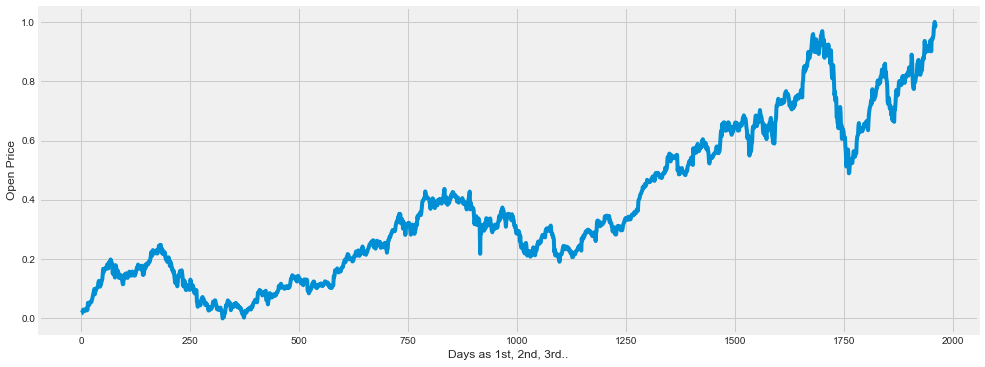

In [15]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

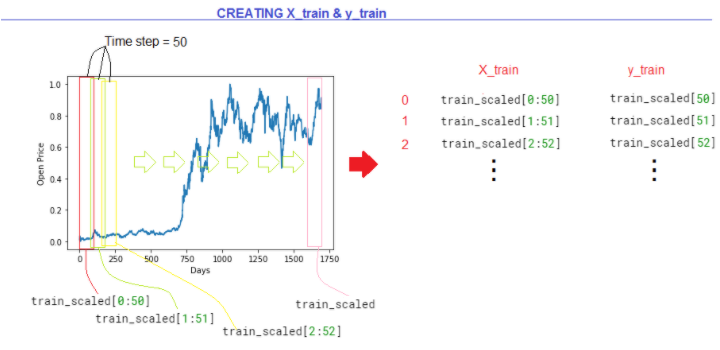

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [16]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [17]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1911, 50)
Shape of y_train before reshape : (1911,)


## Reshape

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (1911, 50, 1)
Shape of y_train after reshape : (1911, 1)


* Shape of X_train : 1134 x 50 x 1
* That means we have 1134 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [19]:
X_train[0]

array([[0.01691719],
       [0.01739081],
       [0.02129843],
       [0.02510342],
       [0.02962678],
       [0.02995041],
       [0.0274006 ],
       [0.02708484],
       [0.02504817],
       [0.02860051],
       [0.03077931],
       [0.03329755],
       [0.0311977 ],
       [0.02739271],
       [0.02931101],
       [0.05247244],
       [0.04767281],
       [0.04449935],
       [0.04558084],
       [0.05338026],
       [0.05560644],
       [0.05362499],
       [0.0547302 ],
       [0.05558274],
       [0.06100604],
       [0.06515047],
       [0.07324987],
       [0.08130192],
       [0.08806719],
       [0.09211689],
       [0.09969528],
       [0.08172819],
       [0.0908933 ],
       [0.09386941],
       [0.09876377],
       [0.1003426 ],
       [0.10396602],
       [0.10526065],
       [0.11051029],
       [0.12124633],
       [0.12646435],
       [0.12336197],
       [0.12429348],
       [0.10711579],
       [0.11748871],
       [0.11582304],
       [0.12333828],
       [0.127

* Check the first item in y_train
* It is the price of 50th day

In [20]:
y_train[0]

array([0.16707189])

<a id="6"></a>
## 6.Creating RNN model 

In [21]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
60/60 [==============================] - 4s 21ms/step - loss: 0.3558 - accuracy: 5.2329e-04
Epoch 2/50
60/60 [==============================] - 1s 21ms/step - loss: 0.1888 - accuracy: 5.2329e-04
Epoch 3/50
60/60 [==============================] - 1s 22ms/step - loss: 0.1248 - accuracy: 0.0010
Epoch 4/50
60/60 [==============================] - 1s 22ms/step - loss: 0.0823 - accuracy: 0.0010
Epoch 5/50
60/60 [==============================] - 1s 22ms/step - loss: 0.0633 - accuracy: 0.0010
Epoch 6/50
60/60 [==============================] - 1s 23ms/step - loss: 0.0523 - accuracy: 0.0010
Epoch 7/50
60/60 [==============================] - 1s 22ms/step - loss: 0.0381 - accuracy: 0.0010
Epoch 8/50
60/60 [==============================] - 1s 22ms/step - loss: 0.0303 - accuracy: 0.0010
Epoch 9/50
60/60 [==============================] - 1s 23ms/step - loss: 0.0256 - accuracy: 0.0010
Epoch 10/50
60/60 [==============================] - 1s 21ms/step - loss: 0.0232 - accuracy: 0.0010
E

<a id="7"></a>
## 7.Evaluating Model

In [22]:
# Losses
history.history["loss"]

[0.3557799160480499,
 0.18877920508384705,
 0.12480749934911728,
 0.08226457238197327,
 0.06332734227180481,
 0.05232616513967514,
 0.038097552955150604,
 0.03032810054719448,
 0.02559734135866165,
 0.023159600794315338,
 0.01884201355278492,
 0.01712166890501976,
 0.014605049975216389,
 0.012409471906721592,
 0.012624292634427547,
 0.01152444165199995,
 0.009908583015203476,
 0.009040344506502151,
 0.008457133546471596,
 0.007916491478681564,
 0.007087783422321081,
 0.006081370171159506,
 0.006305688992142677,
 0.005844862665981054,
 0.0053850384429097176,
 0.005046483129262924,
 0.00546063669025898,
 0.004312732722610235,
 0.004334640689194202,
 0.004119690041989088,
 0.0039229001849889755,
 0.004111215937882662,
 0.0038603509310632944,
 0.0038522600661963224,
 0.0035273549146950245,
 0.0035023048985749483,
 0.0037880551535636187,
 0.0033473868388682604,
 0.0031757308170199394,
 0.0030119481962174177,
 0.0029805987142026424,
 0.002764711854979396,
 0.0028351228684186935,
 0.003069512

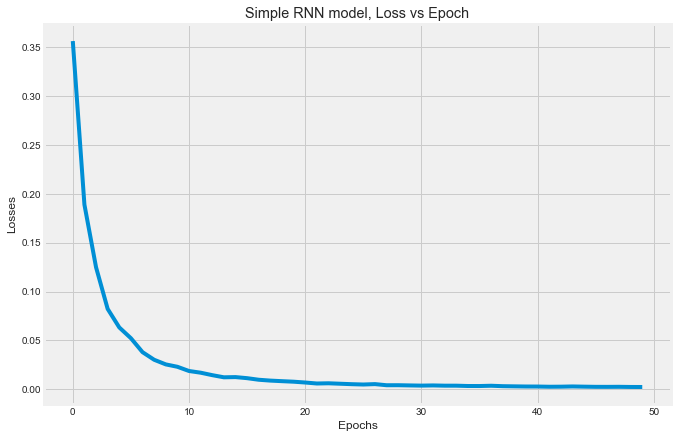

In [23]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

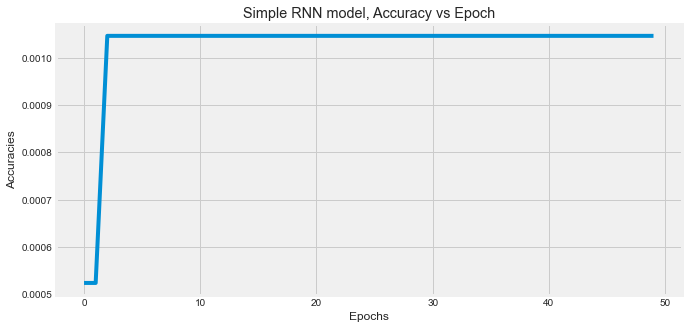

In [24]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data 

In [25]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

60/60 [==============================] - 1s 7ms/step


(1911, 1)

In [26]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(1911, 1)

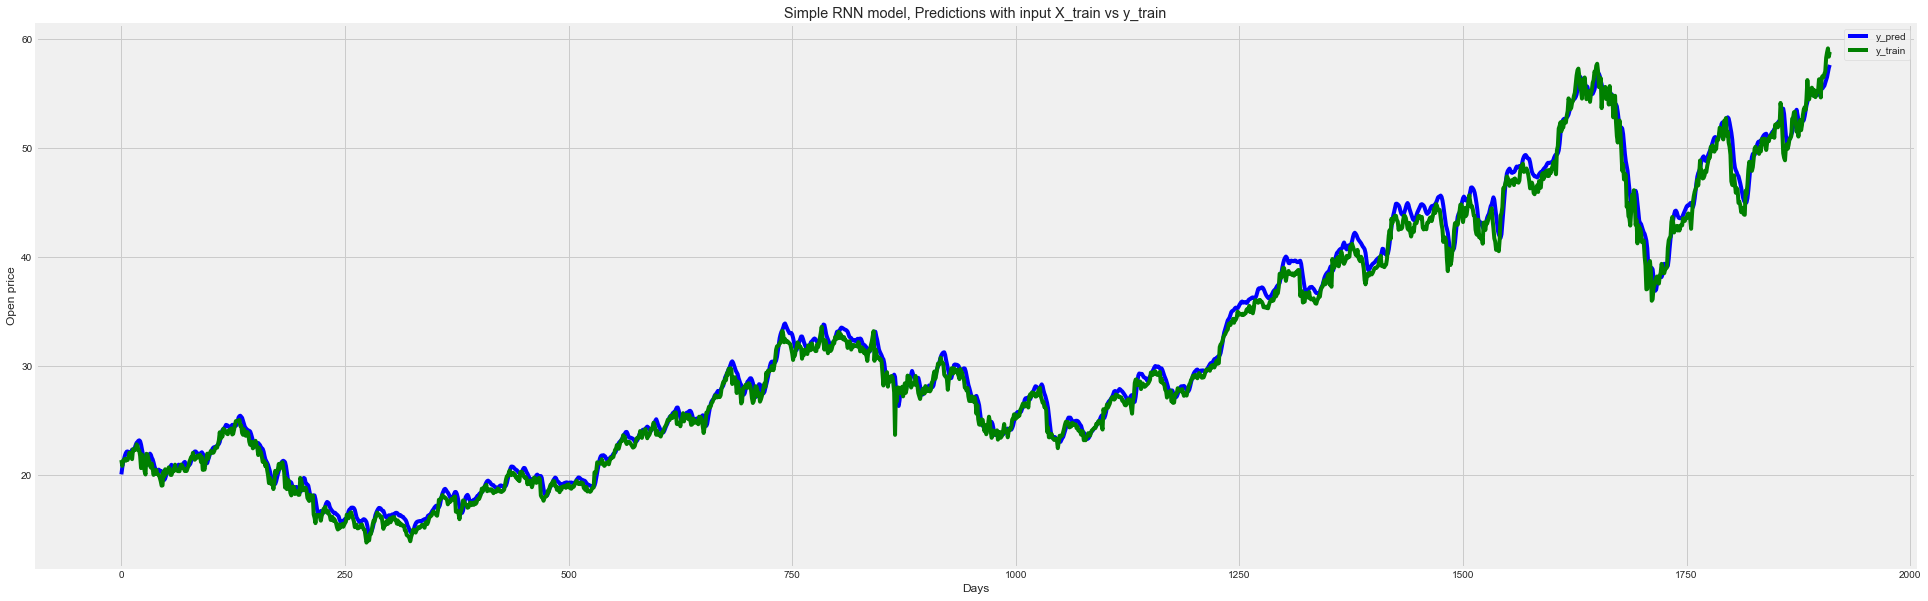

In [27]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data 

### Converting array and scaling

In [28]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (840, 1)


### Creating X_test and y_test

In [29]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [30]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [31]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (790, 50)
Shape of y_test before reshape : (790,)


### Reshape

In [32]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [33]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (790, 50, 1)
Shape of y_test after reshape : (790, 1)


<a id="9"></a>
## 9.Evaluating with Validation Data 

In [34]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

25/25 [==============================] - 0s 8ms/step
Shape of y_pred_of_test : (790, 1)


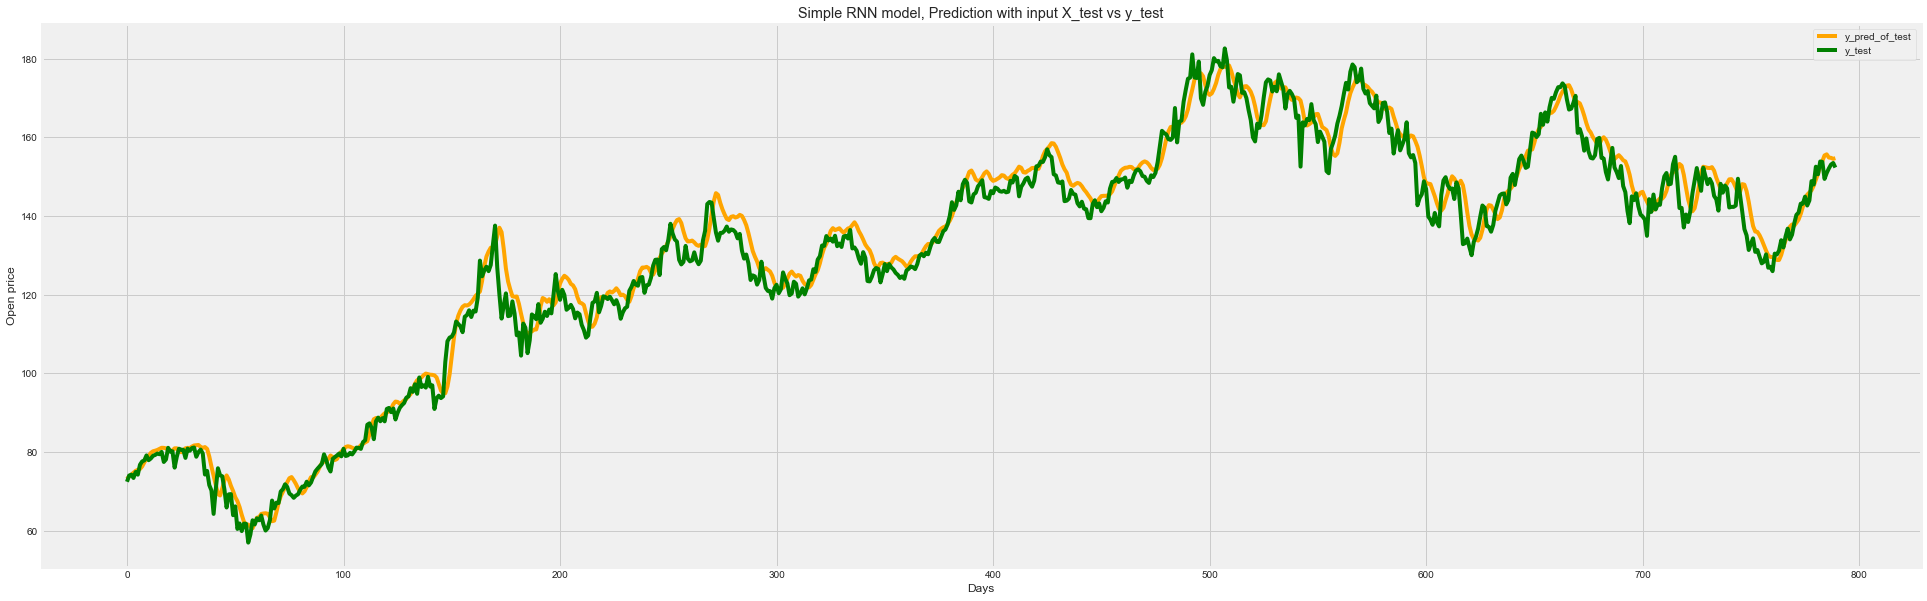

In [35]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [40]:
# Visualisation
rmse = np.sqrt(np.mean(((y_pred_of_test - y_test) ** 2)))
rmse

135.20400842092758

<a id="10"></a>
## 10.Creating LSTM Model

In [41]:
y_train = scaler.fit_transform(y_train)

In [42]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
192/192 [==============================] - 7s 22ms/step - loss: 0.0043 - accuracy: 0.0010
Epoch 2/10
192/192 [==============================] - 4s 21ms/step - loss: 7.2611e-04 - accuracy: 0.0010
Epoch 3/10
192/192 [==============================] - 5s 27ms/step - loss: 6.0651e-04 - accuracy: 0.0010
Epoch 4/10
192/192 [==============================] - 5s 26ms/step - loss: 6.7771e-04 - accuracy: 0.0010
Epoch 5/10
192/192 [==============================] - 4s 22ms/step - loss: 4.7909e-04 - accuracy: 0.0010
Epoch 6/10
192/192 [==============================] - 4s 22ms/step - loss: 4.5620e-04 - accuracy: 0.0010
Epoch 7/10
192/192 [==============================] - 4s 22ms/step - loss: 4.3913e-04 - accuracy: 0.0010
Epoch 8/10
192/192 [==============================] - 4s 22ms/step - loss: 3.9727e-04 - accuracy: 0.0010
Epoch 9/10
192/192 [==============================] - 4s 22ms/step - loss: 3.9592e-04 - accuracy: 0.0010
Epoch 10/10
192/192 [==============================] - 4s 2

<a id="11"></a>
## 11.Evaluating LSTM Model

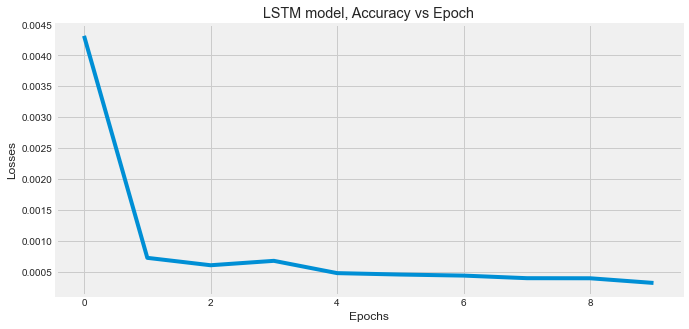

In [43]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

25/25 [==============================] - 1s 10ms/step


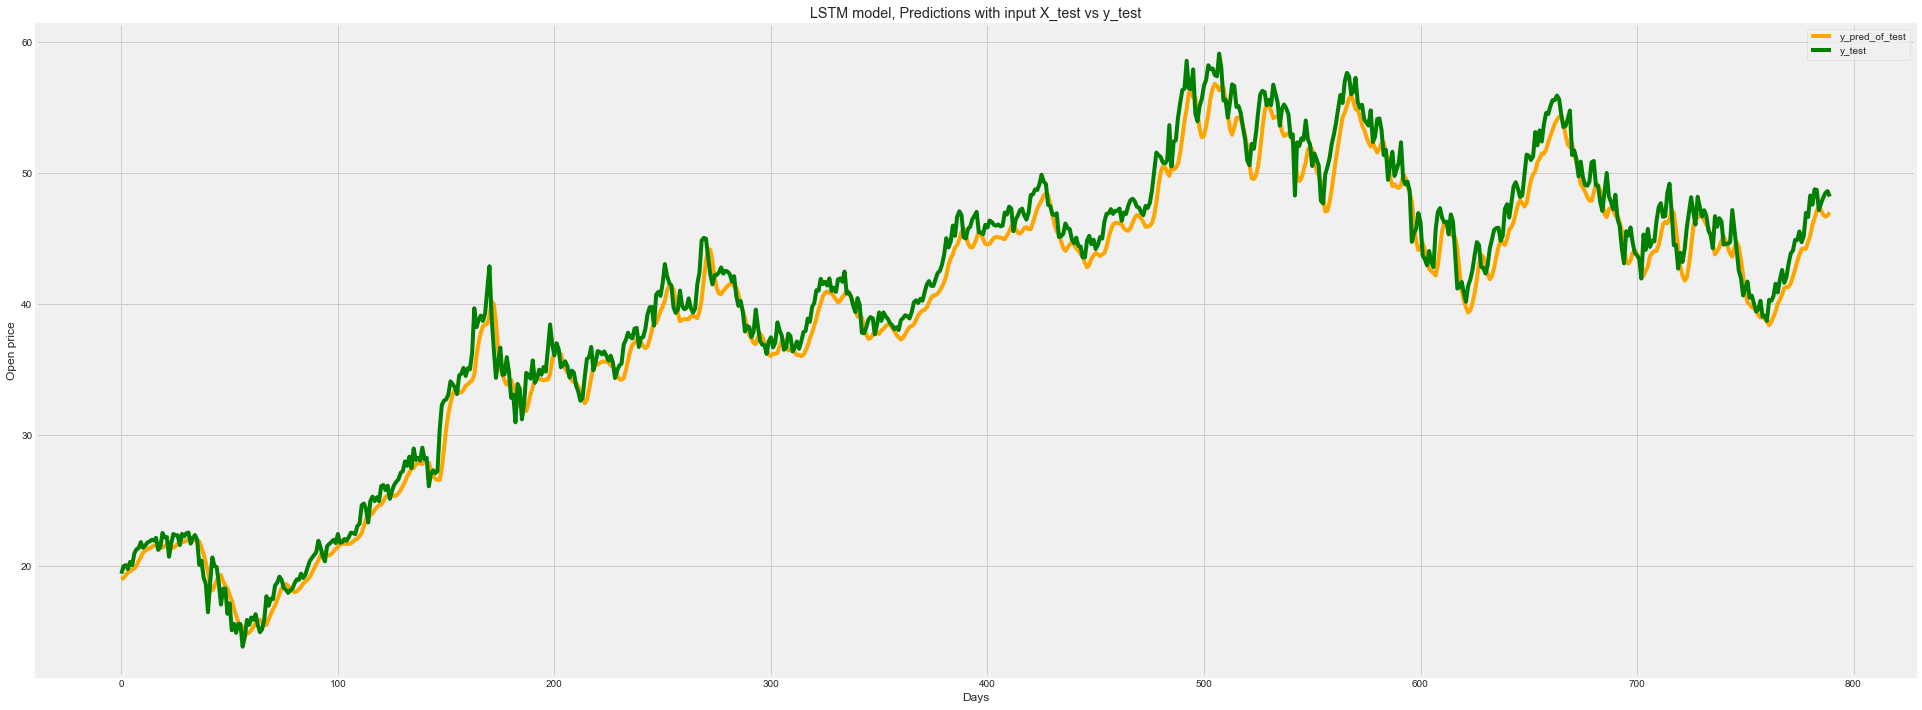

In [44]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

In [50]:
# Visualisation
rmse = np.sqrt(np.mean(((y_pred_of_test - y_test) ** 2)))
rmse

135.20400842092758

<a id="12"></a>
## 12.Future price prediction

* Which day is the last day in our data?

In [46]:
data.iloc[-1]

Open         1.523500e+02
High         1.530000e+02
Low          1.508500e+02
Close        1.525500e+02
Adj Close    1.525500e+02
Volume       5.909590e+07
Name: 2023-02-17 00:00:00, dtype: float64

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [47]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.58055252],
        [0.5866522 ],
        [0.58593443],
        [0.59885157],
        [0.84284161],
        [0.69393621],
        [0.54180111],
        [0.38320772],
        [0.32651588],
        [0.19303899],
        [0.25008945],
        [0.29924661],
        [0.17617494],
        [0.19268038],
        [0.13132385],
        [0.07104397],
        [0.08611415],
        [0.1532112 ],
        [0.03157507],
        [0.0401864 ],
        [0.        ],
        [0.16002866],
        [0.15249343],
        [0.18801569],
        [0.28238256],
        [0.21600273],
        [0.31646928],
        [0.38787241],
        [0.28955863],
        [0.33261556],
        [0.43451711],
        [0.5130963 ],
        [0.53390728],
        [0.61571562],
        [0.61535701],
        [0.67994269],
        [0.59885157],
        [0.64442043],
        [0.82131286],
        [0.79009668],
        [0.95299615],
        [0.88374578],
        [1.        ],
        [0.99641169],
        [0.84140661],
        [0

In [48]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

1/1 [==============================] - 0s 75ms/step
Simple RNN, Open price prediction for 3/18/2017      : 151.96283
LSTM prediction, Open price prediction for 3/18/2017 : 151.43932
